In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [37]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

using Plots

Define start network and default model parameters:

In [38]:
# start_topology = w_frozen_osc

# start_network = (0.9995 .^ rand(0:10000,Ng,Ng+1)) .* 10 .* rand(Ng,Ng+1) .* start_topology

# start_network = (0.9995 .^ rand(0:10000,Ng,Ng+1)) .* 10 .* rand(Ng,Ng+1)

grn_parameters = DefaultGRNParameters();

In [39]:
example_networks = load(datadir("exp_pro/80-40-80_networks/examples.jld"))

Dict{String, Any} with 6 entries:
  "bistable"     => NaN
  "feed_forward" => [0.0 0.0 0.0 0.19495; 0.173532 0.0 0.0 0.0; 3.02262 -5.5322…
  "classical"    => [0.0 0.0 0.0 0.114353; -0.560775 0.359711 0.0 0.0; -0.07258…
  "frozen_osc"   => NaN
  "mutual_inh"   => [0.0 0.0 0.0 0.2454; 0.455819 0.0 -2.23319 0.0; 0.446651 -2…
  "overlap_dom"  => [0.0 0.0 -0.00379469 0.228214; 0.653415 0.0 0.0 0.0; -0.424…

In [40]:
start_network = example_networks["classical"]

3×4 Matrix{Float64}:
  0.0         0.0       0.0       0.114353
 -0.560775    0.359711  0.0       0.0
 -0.0725802  -0.407225  0.527974  0.0

In [41]:
start_ind = Individual(start_network,grn_parameters,DefaultGRNSolver());

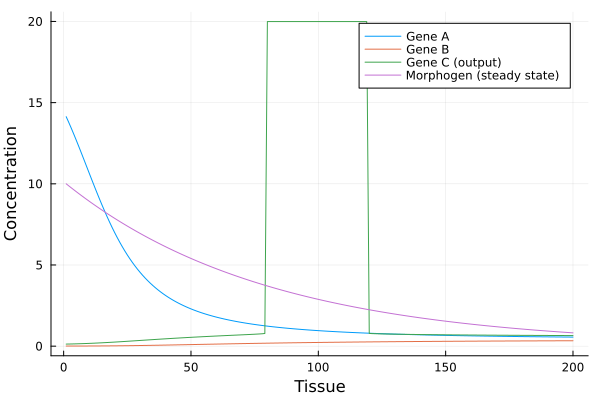

In [42]:
plot_SS(start_ind.phenotype.u[end])

In [43]:
f_sim_eval(start_ind.phenotype.u[end][3,:],5.,5.)

(1.0, 1.0, Any[79.0, 40.0, 80.0])

In [44]:
viable_mutations = ones(Ng,Ng+1)
viable_mutations[2,4] = 0.
viable_mutations[3,4] = 0.
viable_mutations

3×4 Matrix{Float64}:
 1.0  1.0  1.0  1.0
 1.0  1.0  1.0  0.0
 1.0  1.0  1.0  0.0

Define mutation:

In [45]:
cv = 1.

mutation_op = MutationOperator(Normal,(μ = 0.0,σ = cv),viable_mutations)

# mutation_op = MutationOperator(Chi,(ν = 1.,),viable_mutations)

# noise_application = (x,n) -> rand() < 0.5 ? x + n : x * n 

noise_application = (x,n) -> x + x*n

# noise_application = (x,n) -> x * n 

mutate_function = i -> noise(i,mutation_op,noise_application);

Define fitness function:

In [46]:
n_stripe = 1

stripe_threshold = 5.

min_width = 5.

output_gene = 3

# target = [20.,40.,140.]

# fitness_function = s -> fitness_evaluation(s,x->f_sim(x,stripe_threshold,n_stripe,target,min_width),output_gene);

target = [(40.,20.)]

fitness_function = s -> fitness_evaluation(s,x->f_sim_cw(x,stripe_threshold,n_stripe,target,min_width),output_gene);

Evolutionary setup:

In [64]:
β = Inf

max_gen = 20000

tolerance = 2.

# p_final, evo_trace, e  = SSWM_Evolution_error(start_network,grn_parameters,β,max_gen,tolerance,fitness_function,mutate_function);

p_final, evo_trace = SSWM_Evolution(start_network,grn_parameters,β,max_gen,tolerance,fitness_function,mutate_function);

Plot convergence of first fitness component (n_stripes):

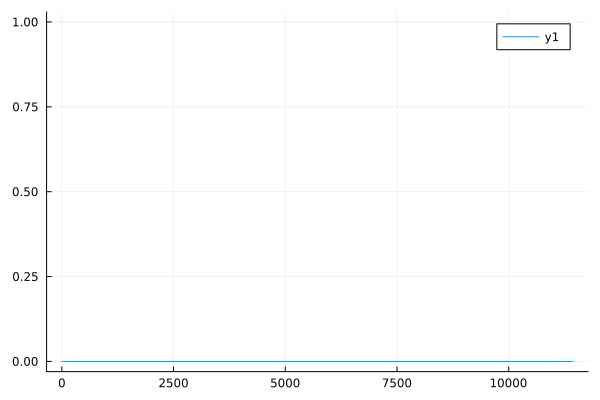

In [65]:
plot(map(x->x[1],evo_trace.fitness_trajectory))

Plot convergence of second fitness component (equalness):

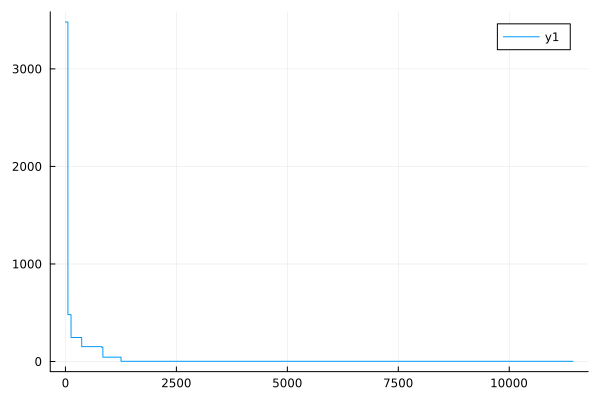

In [66]:
plot(map(x->x[2],evo_trace.fitness_trajectory))

Check out phenotype:

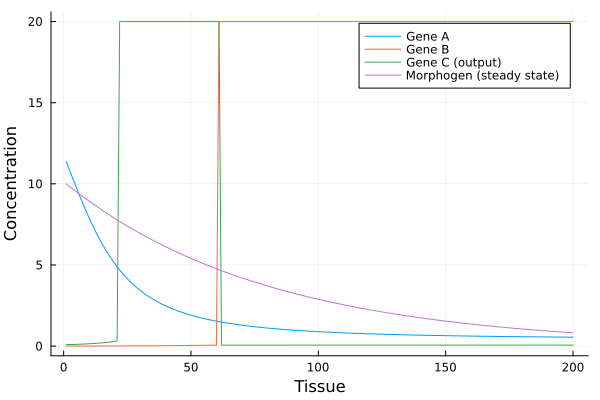

In [67]:
plot_SS(p_final.dominant_individual.phenotype.u[end])

In [68]:
evo_trace.traversed_phenotypes

11436-element Vector{Vector{Any}}:
 [(99.0, 20.0)]
 [(99.0, 20.0)]
 [(99.0, 20.0)]
 [(99.0, 20.0)]
 [(99.0, 20.0)]
 [(99.0, 20.0)]
 [(99.0, 20.0)]
 [(99.0, 20.0)]
 [(99.0, 20.0)]
 [(99.0, 20.0)]
 ⋮
 [(39.5, 18.5)]
 [(39.5, 18.5)]
 [(39.5, 18.5)]
 [(39.5, 18.5)]
 [(39.5, 18.5)]
 [(39.5, 18.5)]
 [(39.5, 18.5)]
 [(39.5, 18.5)]
 [(41.0, 20.0)]

In [69]:
f_sim_eval(p_final.dominant_individual.phenotype.u[end][3,:],stripe_threshold,min_width)

(1.0, 1.0, Any[21.0, 40.0, 138.0])

In [ ]:
function get_centres_and_width(v)
    return v[1] + 0.5*v[2], v[2]
end

pheno_path_cw = map(x->get_centres_and_width(x[3]),evo_trace.fitness_trajectory);

plot(pheno_path_cw,seriestype = :path,xaxis = "centre position",yaxis = "width")
scatter!(collect(keys(countmap(pheno_path_cw))),zcolor = Float64.(collect(values(countmap(pheno_path_cw)))) ./ length(pheno_path_cw))

In [ ]:
pheno_path_1 = map(x->x[3][1],evo_trace.fitness_trajectory)
pheno_path_2 = map(x->x[3][2],evo_trace.fitness_trajectory)
pheno_path_3 = map(x->x[3][3],evo_trace.fitness_trajectory)

plot(pheno_path_1,pheno_path_2,pheno_path_3,seriestype = :path, camera = (70,30))

# https://discourse.julialang.org/t/animation-from-data-points-arrays/40642/2
# do average then ribbon for error bars

In [ ]:
p_final.dominant_individual.genotype.p[1]

In [ ]:
count(x->x==:MaxIters,evo_trace.retcodes)/length(evo_trace.retcodes)

Run evolution for an extended period, using previous output as start population:

In [ ]:
max_gen = 100000

SSWM_Evolution!(p_final,evo_trace,β,max_gen,tolerance,fitness_function,mutate_function)

In [ ]:
p_final.fitness

In [ ]:
# frozen osc

# 2.45845  -2.18826  -0.654486  0.100882
#  0.0       0.33589   0.0       0.0
#  3.61625  -6.32603   0.0       0.0

# position 50, width = 20 frozen osc

# 2.46532  -2.18916   -0.482151  0.100882
# 0.0       0.336411   0.0       0.0
# 3.8587   -5.86916    0.0       0.0

# frozen 2 stripe

# 2.46532  -2.18916   -0.482151  0.22361
# 0.0       0.463721   0.0       0.0
# 3.85257  -6.03316    0.0       0.0

In [ ]:
findall(x-> x!= :Terminated,evo_trace.retcodes)

In [ ]:
length(evo_trace.retcodes)

In [ ]:
evo_trace.retcodes[736]

In [ ]:
# dider stripe
# 2.4617   -2.01504   -0.482151  0.0698463
# 0.0       0.428295   0.0       0.0
# 3.96334  -6.27255    0.0       0.0